# Monte Carlo price simulation

## Libraries

In [34]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, shapiro

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Dataset

In [35]:
df = pd.read_csv("afh-moneypl-1583659392916.csv",
                 index_col="Data", parse_dates=True)
df.head()

,Otwarcie,Zamknięcie,Maks.,Min.,Obrót (mln. zł),Zmiana (%)
Data,,,,,,
2020-03-06,11.4,10.4,11.5,10.3,0.03,0.00
2020-03-06,11.4,10.4,11.5,10.3,0.03,-9.57
2020-03-05,10.0,11.5,12.0,10.0,0.01,0.88
2020-03-04,11.1,11.4,11.9,10.4,0.02,-9.52
2020-03-03,12.0,12.6,12.8,11.0,0.01,-1.56


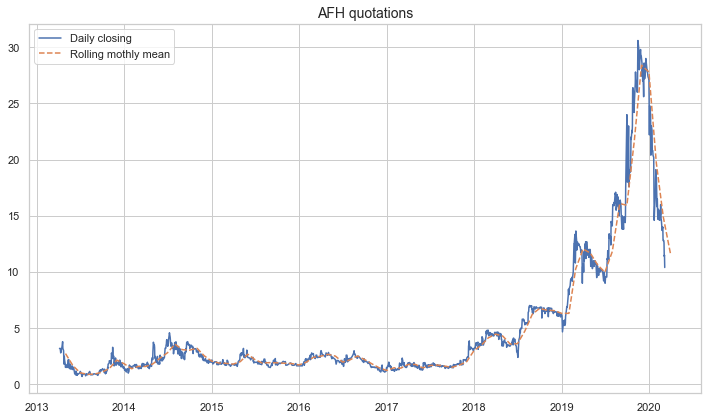

In [36]:
fig = plt.figure(figsize=(10, 6))
plt.plot(df["Zamknięcie"])
plt.plot(df["Zamknięcie"].resample("M").mean(), linestyle="dashed")
plt.title("AFH quotations", size=14)
plt.legend(["Daily closing", "Rolling mothly mean"])
plt.tight_layout()
plt.show()

## Descriptive statistics

### Daily returns mean, variance, standard deviation

In [37]:
afh_returns = df["Zmiana (%)"]/100
afh_average_returns = np.mean(afh_returns)
afh_var = np.var(afh_returns)
afh_std = np.std(afh_returns)
print(f"Average return rate: {afh_average_returns.round(3)}",
      f"variance: {afh_var.round(3)}", f"Standard deviation: {afh_std.round(3)}")

Average return rate: 0.005 variance: 0.008 Standard deviation: 0.088


### Daily returns volitility

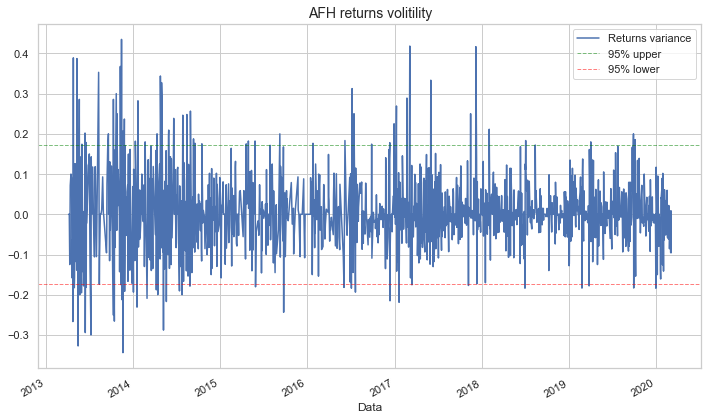

In [38]:
fig = plt.figure(figsize=(10, 6))

# plotting
afh_returns.plot()

# 95% bounaries
plt.axhline(1.96*afh_returns.std(),
            linestyle="dashed", lw=1, color="green", alpha=0.5)
plt.axhline(-1.96*afh_returns.std(),
            linestyle="dashed", lw=1, color="red", alpha=0.5)
plt.title("AFH returns volitility", size=14)
plt.legend(["Returns variance", "95% upper", "95% lower"])

plt.tight_layout()
plt.show()

### Daily returns distribution and test for normality 

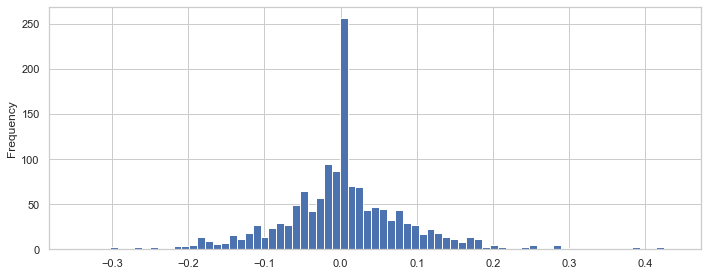

In [39]:
fig = plt.figure(figsize=(10, 4))

afh_returns.plot(kind="hist", bins=75)

plt.tight_layout()
plt.show()

In [40]:
print("Kurtosis:",kurtosis(afh_returns))
print("Skewness:", skew(afh_returns))

Kurtosis: 2.919264849575816
Skewness: 0.5066381153276922


#### Shapiro-Wilk test

In [41]:
normality_test = shapiro(afh_returns)[1]

if normality_test <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


## Monte Carlo simulation

In [42]:
# one simulation function
def sim(days_ahead):

    initial_price = df.iloc[0, 1]
    price = [initial_price]

    # expected rate of change each day
    # other solution risk free rate - (var/2) or simply zero
    afh_drift = afh_average_returns - (afh_var/2)

    for d in range(days_ahead):
        afh_today_price = price[-1] * \
            (1 + afh_drift + afh_std * np.random.normal())
        price.append(afh_today_price)

    return price

In [43]:
days_ahead = 90
simulations = 5000
results = np.empty((simulations, days_ahead+1))

for s in range(simulations):
    results[s] = sim(days_ahead)

In [44]:
#agregating results
days_ahead_index = pd.date_range(start=df.index[0], periods=days_ahead+1, freq="D")
all_results = pd.DataFrame(data=results.T, index=days_ahead_index)
all_results.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
2020-03-06,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,...,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000,10.400000
2020-03-07,10.368068,12.255127,10.283742,8.303882,10.696054,12.985874,11.949690,10.566703,12.225191,10.237713,...,8.156515,9.454439,10.228003,11.265881,9.920910,9.989296,9.349911,10.472965,10.180307,8.772185
2020-03-08,10.908525,12.357180,12.234963,7.678704,10.198599,12.841221,10.480779,11.963271,12.313541,11.531575,...,9.177384,10.387706,10.081544,10.899834,8.275876,10.421793,9.769656,10.609263,10.607346,8.290797
2020-03-09,10.093950,11.009681,12.976699,7.867203,10.549523,12.056647,10.207381,12.202859,13.352471,10.146116,...,10.248521,10.549654,12.782869,10.502649,9.440329,10.103956,10.129593,11.715187,11.153390,8.280385
2020-03-10,11.151662,9.817510,12.777050,7.687890,11.001866,12.800937,10.129708,9.552835,13.934349,10.548606,...,8.779547,9.286480,13.132586,10.171614,10.639219,9.416260,9.149904,12.236062,11.840472,9.241607


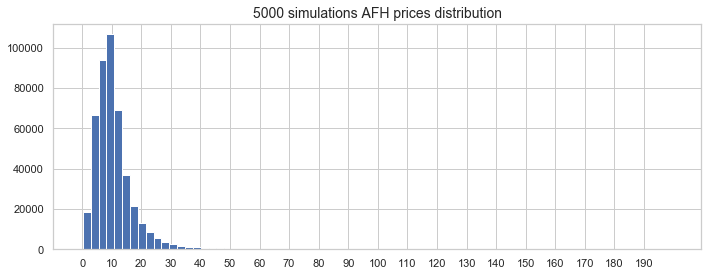

In [45]:
fig = plt.figure(figsize=(10, 4))

plt.hist(all_results.values.reshape(-1,1), bins=75)
plt.xticks([tick for tick in range(0,int(np.max(all_results.values)),10)])
plt.title(f"{simulations} simulations AFH prices distribution", size=14)

plt.tight_layout()
plt.show()

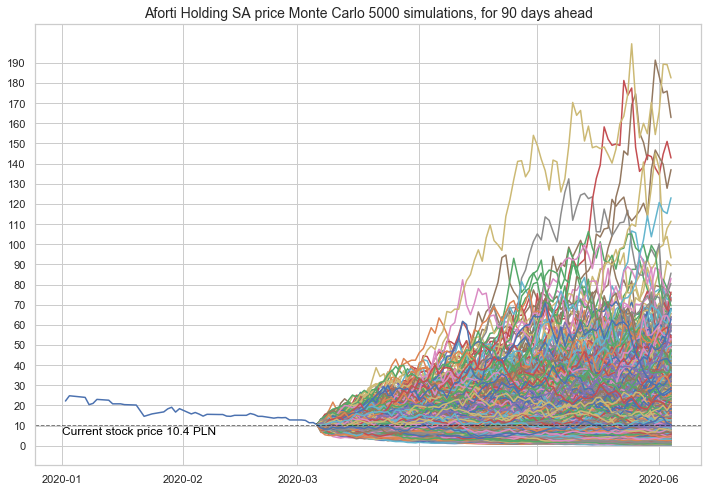

In [46]:
fig = plt.figure(figsize=(10, 7))

plt.plot(df[df.index > "2019-12-31"]["Zamknięcie"])
plt.plot(all_results)
plt.title(f"Aforti Holding SA price Monte Carlo {simulations} simulations, for {days_ahead} days ahead", size=14)
plt.axhline(df.iloc[0, 1], linestyle="dashed", color="black", alpha=0.5, lw=1)
plt.annotate(f"Current stock price {df.iloc[0,1]} PLN", xy=(pd.datetime(2020, 1, 1), df.iloc[0, 1]-5), color="black")
plt.yticks([tick for tick in range(0,int(np.max(all_results.values)),10)])

plt.tight_layout()
plt.show()